In [181]:
!pip install pykan

In [182]:
!pip show pykan

Name: pykan
Version: 0.2.8
Summary: Kolmogorov Arnold Networks
Home-page: 
Author: Ziming Liu
Author-email: zmliu@mit.edu
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: 


In [183]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from kan import KAN
import uuid

# Установка сида для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Проверка доступности CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [184]:
# Генерация данных
def true_function(x):
    return np.sin(np.pi * x) * np.exp(-x**2) + 0.1 * np.cos(5 * x)

x_train_kan = np.linspace(-2, 2, 200).reshape(-1, 1)
y_train_kan = true_function(x_train_kan)
x_test_kan = np.linspace(-2, 2, 100).reshape(-1, 1)
y_test_kan = true_function(x_test_kan)

x_train_mlp = np.linspace(-2, 2, 2000).reshape(-1, 1)
y_train_mlp = true_function(x_train_mlp)
x_test_mlp = np.linspace(-2, 2, 200).reshape(-1, 1)
y_test_mlp = true_function(x_test_mlp)

In [185]:
# Перенос тензоров на устройство
x_train_tensor_kan = torch.tensor(x_train_kan, dtype=torch.float32).to(device)
y_train_tensor_kan = torch.tensor(y_train_kan, dtype=torch.float32).to(device)
x_test_tensor_kan = torch.tensor(x_test_kan, dtype=torch.float32).to(device)
y_test_tensor_kan = torch.tensor(y_test_kan, dtype=torch.float32).to(device)

x_train_tensor_mlp = torch.tensor(x_train_mlp, dtype=torch.float32).to(device)
y_train_tensor_mlp = torch.tensor(y_train_mlp, dtype=torch.float32).to(device)
x_test_tensor_mlp = torch.tensor(x_test_mlp, dtype=torch.float32).to(device)
y_test_tensor_mlp = torch.tensor(y_test_mlp, dtype=torch.float32).to(device)

In [186]:
# Определение MLP архитектур
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.ReLU())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [187]:
# Функция обучения MLP с сохранением истории ошибок
def train_mlp(model, x, y, epochs=1000, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return model, loss_history

In [188]:
# Создание трех MLP с разными гиперпараметрами
mlp_configs = [
    {"layers": [1, 10, 10, 1], "epochs": 100, "lr": 0.01, "name": "MLP Simple"},
    {"layers": [1, 50, 50, 1], "epochs": 200, "lr": 0.005, "name": "MLP Medium"},
    {"layers": [1, 100, 100, 100, 1], "epochs": 300, "lr": 0.001, "name": "MLP Deep"},
]

mlp_models = []
mlp_predictions = []
mlp_mse = []
mlp_loss_histories = []

for config in mlp_configs:
    mlp_model = MLP(config["layers"])
    mlp_model, loss_history = train_mlp(mlp_model, x_train_tensor_mlp, y_train_tensor_mlp, config["epochs"], config["lr"])
    mlp_models.append(mlp_model)
    mlp_loss_histories.append(loss_history)
    with torch.no_grad():
        y_pred = mlp_model(x_test_tensor_mlp).cpu().numpy()  # Перенос на CPU для numpy
        mlp_predictions.append(y_pred)
        mse = np.mean((y_pred - y_test_mlp)**2)
        mlp_mse.append(mse)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.14e-02 | test_loss: 1.13e-02 | reg: 3.75e+00 | : 100%|█| 200/200 [00:24<00:00,  8.18


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.18e-02 | test_loss: 1.19e-02 | reg: 3.54e+00 | : 100%|█| 200/200 [00:22<00:00,  9.04


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.04e-03 | test_loss: 9.02e-03 | reg: 3.42e+00 | : 100%|█| 200/200 [00:30<00:00,  6.48


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.97e-02 | test_loss: 1.97e-02 | reg: 4.66e+00 | : 100%|█| 200/200 [00:24<00:00,  8.23


saving model version 0.1


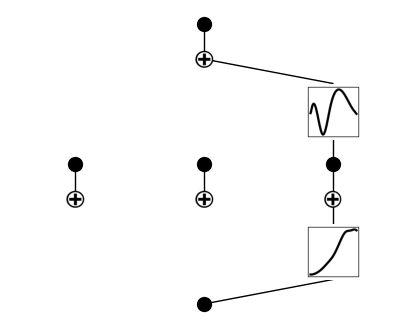

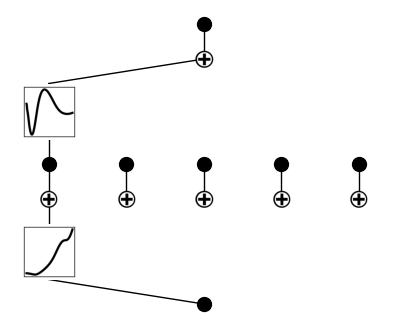

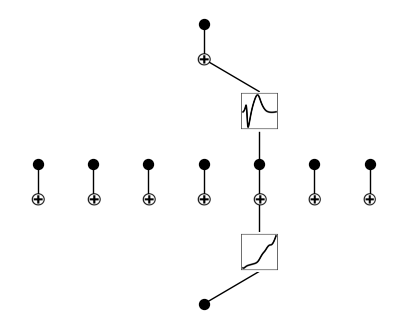

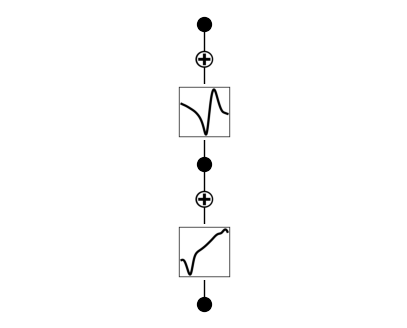

In [189]:
# Создание и обучение KAN моделей
kan_configs = [
    {"width": [1, 3, 1], "grid": 8, "k": 3, "name": "KAN Optimal"},
    {"width": [1, 5, 1], "grid": 10, "k": 3, "name": "KAN Medium"},
    {"width": [1, 7, 1], "grid": 15, "k": 3, "name": "KAN Complex"},
    {"width": [1, 1, 1], "grid": 15, "k": 3, "name": "KAN Complex"},
]

kan_models = []
kan_predictions = []
kan_mse = []
kan_loss_histories = []

for config in kan_configs:
    kan_model = KAN(width=config["width"], grid=config["grid"], k=config["k"], device=device)
    dataset = {
        "train_input": x_train_tensor_kan,
        "train_label": y_train_tensor_kan,
        "test_input": x_test_tensor_kan,
        "test_label": y_test_tensor_kan
    }
    results = kan_model.fit(dataset, opt="LBFGS", steps=200, lamb=0.01)
    kan_model(dataset['train_input']);
    kan_model.plot(beta=100)
    kan_models.append(model)
    y_pred = kan_model(x_test_tensor_kan).detach().cpu().numpy()  # Перенос на CPU для numpy
    kan_predictions.append(y_pred)
    mse = np.mean((y_pred - y_test_kan)**2)
    kan_mse.append(mse)
    # Сохранение истории лоссов (train_loss из результатов fit)
    kan_loss_histories.append(results['train_loss'])


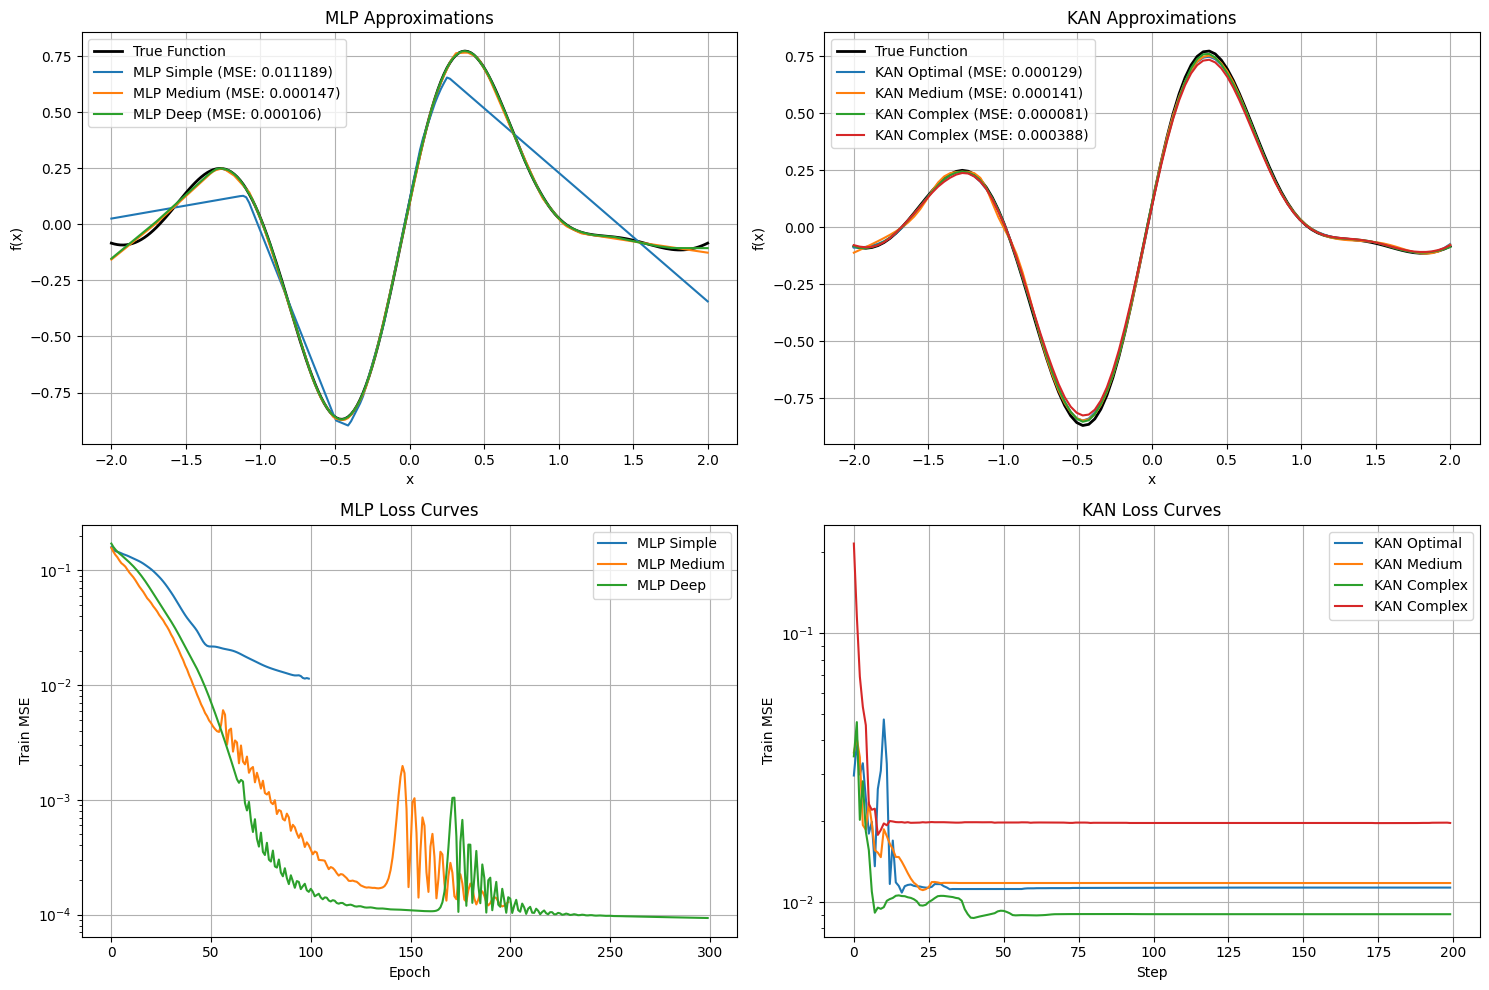

In [190]:
# Визуализация аппроксимаций
plt.figure(figsize=(15, 10))

# График для MLP
plt.subplot(2, 2, 1)
plt.plot(x_test_mlp, y_test_mlp, label="True Function", color="black", linewidth=2)
for i, pred in enumerate(mlp_predictions):
    plt.plot(x_test_mlp, pred, label=f"{mlp_configs[i]['name']} (MSE: {mlp_mse[i]:.6f})")
plt.title("MLP Approximations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

# График для KAN
plt.subplot(2, 2, 2)
plt.plot(x_test_kan, y_test_kan, label="True Function", color="black", linewidth=2)
for i, pred in enumerate(kan_predictions):
    plt.plot(x_test_kan, pred, label=f"{kan_configs[i]['name']} (MSE: {kan_mse[i]:.6f})")
plt.title("KAN Approximations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

# Визуализация изменения ошибок для MLP
plt.subplot(2, 2, 3)
for i, loss_history in enumerate(mlp_loss_histories):
    plt.plot(range(len(loss_history)), loss_history, label=mlp_configs[i]['name'])
plt.title("MLP Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Train MSE")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Логарифмическая шкала для лучшей видимости

# Визуализация изменения ошибок для KAN
plt.subplot(2, 2, 4)
for i, loss_history in enumerate(kan_loss_histories):
    plt.plot(range(len(loss_history)), loss_history, label=kan_configs[i]['name'])
plt.title("KAN Loss Curves")
plt.xlabel("Step")
plt.ylabel("Train MSE")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Логарифмическая шкала для лучшей видимости

plt.tight_layout()
plt.savefig("mlp_kan_comparison.png")

In [191]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    kan_model.fix_symbolic(0,0,0,'sin');
    kan_model.fix_symbolic(0,1,0,'x^2');
    kan_model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs', 'cos']
    kan_model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.8871012330055237, c=1
fixing (1,0,0) with x, r2=0.001665284507907927, c=1
saving model version 0.2


In [192]:
kan_model.symbolic_formula()[0][0]

0.0125003611518125*x_1 - 0.00616249819743619

In [193]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"KAN params: {count_parameters(kan_model)}")
print(f"MLP params: {count_parameters(mlp_model)}")

KAN params: 48
MLP params: 20501


In [194]:
def plot_kan_weights(model):
    for i, layer in enumerate(model.linears):
        weights = layer.weight.detach().cpu().numpy()
        plt.figure(figsize=(6, 2))
        plt.imshow(weights, cmap='bwr', aspect='auto')
        plt.colorbar()
        plt.title(f"Layer {i} Weights")
        plt.xlabel("Input Neurons")
        plt.ylabel("Output Neurons")
        plt.tight_layout()
        plt.show()